In [238]:
import os
import pandas as pd
import re

import nltk
#nltk.download('punkt')
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import FreqDist
from nltk import ngrams
from nltk.corpus import stopwords

import numpy as np
import altair as alt
import seaborn as sns

from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import spacy
from spacy.lang.ja.examples import sentences 

In [2]:
#import spacy.cli
#spacy.cli.download("en")
#spacy.cli.download("it")

In [211]:
import spacy
nlp_en = spacy.load('en_core_web_lg',disable=["tok2vec",  "parser"])
nlp_it = spacy.load('it_core_news_lg',disable=["tok2vec", "parser"])

In [212]:
#!python -m spacy download en_core_web_lg

In [213]:
#from google.colab import drive
#drive.mount('/content/drive')

In [214]:
#!unzip /content/drive/MyDrive/progettone/lyrics_final_2.zip -d /content/drive/MyDrive/progettone/lyrics

In [215]:
DATA = "songlyrics/lyrics"

In [216]:
df = pd.read_csv("songs_with_filenames_and_feats_and_lang_5.csv", delimiter=";")
df = df[df['index'].notna()]

In [217]:
songs = os.listdir(DATA)

In [218]:
print(f"found {len(songs)} unique files") 

found 5832 unique files


In [286]:
df_eng = df[df["lang"]=="English"]

In [287]:
df_it = df[df["lang"]=="Italian"]

In [221]:
#plt.figure(figsize=(30,5))
#ax = sns.countplot(x="year", data=df_eng)

In [222]:
#plt.figure(figsize=(30,5))
#ax = sns.countplot(x="year", data=df_it)

In [223]:
data_eng = list()
for song in df_eng["index"]:
    with open(os.path.join(DATA,song),"r",encoding='utf-8') as file:
        lyrics = file.read()
        data_eng.append(lyrics)

In [224]:
data_ita = list()
for song in df_it["index"]:
    with open(os.path.join(DATA,song),"r",encoding='utf-8') as file:
        lyrics = file.read()
        data_ita.append(lyrics)

In [231]:
def preprocess(data, vocabulary, processed_data, nlp_model):
    for lyric in nlp_model.pipe(data, n_process=8):
        r = [tok.lemma_ for tok in lyric if not tok.is_stop and tok.is_alpha]
        cleaned_song = []
        for i in r:
            if len(i) > 2:
                vocabulary.append(i)
                cleaned_song.append(i)
        processed_data.append(" ".join(cleaned_song))

In [232]:
bag_eng = list()
songs_eng = list()
preprocess(data_eng, bag_eng, songs_eng, nlp_en)

In [233]:
bag_ita = list()
songs_ita = list()
preprocess(data_ita, bag_ita, songs_ita,nlp_it)

In [ ]:
#nltk.download('stopwords')

In [239]:
stop_extra_en = ["la", "yeah", "oh", "ooh", "doo", "da", "gon", "gon", "na", "ayy","ay","La", "woah", "mmm", "nah", "yes","ha","ba","mi", "Ai" "Yeah","huh", "wo", "ah", "ai", "ta", "da", "uh", "ya", "hey", "come", "go", "let", "take", "woo", "til", "o", "e", "eh", "yo"]
stops_en = stopwords.words('english') + stop_extra_en
stop_extra_it = ["ehi", "il", "eh",  "sì", "uoh", "oh", "na", "eh", "qua", "che", "yeah", "poi","solo", "così","qui",'yah', "già",'prima','quel','fra',"quando", "sei", "skrrt", "ora", "mai", "bang", "fare","nun","ogni","forse","però", 'yah',  'uoh', 'brr']
stops_it = stopwords.words('italian') + stop_extra_it

In [ ]:
#stops_it

In [240]:
distribution = FreqDist(bag_ita)

In [242]:
#[i for i in distribution.most_common() if len(i[0]) > 2 and i[0].lower() not in stops_it]

In [243]:
#distribution

In [337]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords


tf_vectorizer = CountVectorizer(stop_words = stops_en, lowercase=True, max_df=0.7, min_df=5, max_features = 200, ngram_range=(1,1))
tf = tf_vectorizer.fit_transform(songs_eng)

In [404]:
from sklearn.decomposition import LatentDirichletAllocation

n_components = 5

lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method = 'batch',
                                n_jobs=-1,verbose=1,random_state=7)
lda.fit(tf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=7, verbose=1)

In [405]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f'Topic {topic_idx}: '
        message += ', '.join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [406]:
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic 0: dude, dance, man, everybody, party, stop, hands, shake, high, work, right, watch, die, like, dream, young, air, wish, wrong, fly
Topic 1: night, better, says, day, way, time, coming, feel, bloom, old, long, eyes, home, good, world, hand, hear, god, said, know
Topic 2: like, got, know, girl, shit, want, bitch, fuck, think, look, wanna, bad, right, people, time, man, low, said, way, need
Topic 3: baby, wanna, want, tonight, know, time, hold, life, run, boy, away, body, rock, good, need, like, got, right, whoa, night
Topic 4: love, know, heart, feel, got, need, way, mind, time, find, little, away, tell, like, life, gone, touch, change, head, things



In [407]:
doc_topics_en = lda.transform(tf)
# panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
# pyLDAvis.save_html(panel, "topics_2.html")

In [408]:
#!pip install wordcloud

In [409]:
from wordcloud import WordCloud

In [410]:
vocab = tf_vectorizer.get_feature_names()

In [411]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index, model, lang, vocab,color):
  imp_words_topic = ""
  comp=model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:20]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400, background_color=color).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.savefig(f'{lang}_topic_{index}.png')
  plt.show()

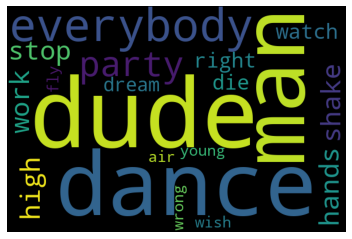

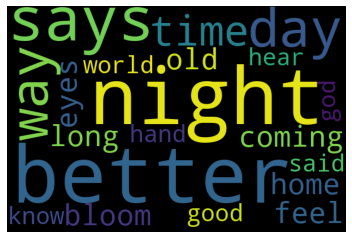

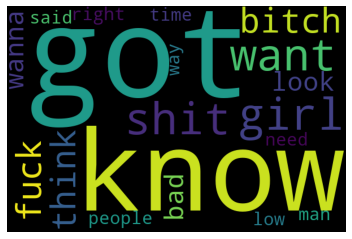

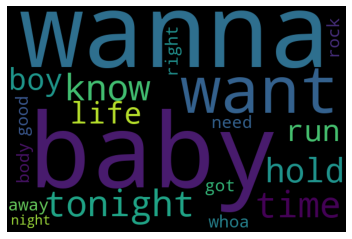

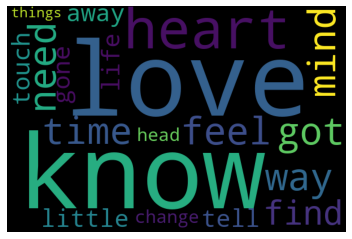

In [412]:
for i in range(5):
    draw_word_cloud(i,lda,"En",vocab,"black")
#party
#rimembranza
#esplicito
#passione
#amore

In [378]:
tf_vectorizer2 = CountVectorizer(stop_words = stops_it, lowercase=True, max_df=0.7, min_df=5, max_features = 200, ngram_range=(1,1))
tf2 = tf_vectorizer2.fit_transform(songs_ita)

In [379]:
n_components = 5

lda2 = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method = 'batch',
                                n_jobs=-1,verbose=1,random_state=6)
lda2.fit(tf2)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=6, verbose=1)

In [380]:
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda2, tf_feature_names, n_top_words)

Topic 0: work, talk, bitch, woman, open, shake, bring, free, makes, late, dark, body, day, wanna, sun, fight, going, mean, baby, feel
Topic 1: falling, die, love, lost, work, babe, life, hit, light, wanna, soul, room, shake, white, watch, knew, feeling, music, body, goes
Topic 2: try, damn, sun, shake, hear, mean, guess, touch, good, think, like, listen, right, real, soul, girls, wanna, gone, care, hate
Topic 3: babe, alright, hard, lost, forever, heart, low, young, old, girl, baby, shake, beautiful, falling, sun, away, floor, set, live, mind
Topic 4: shake, work, new, rain, baby, fight, soul, okay, true, eyes, cold, wrong, way, mean, face, walk, alive, hit, real, room



In [381]:
vocab2 = tf_vectorizer2.get_feature_names()

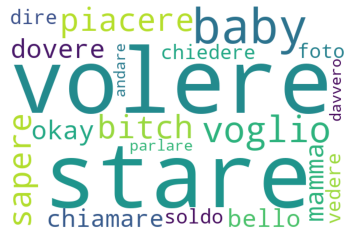

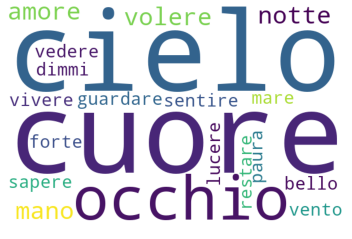

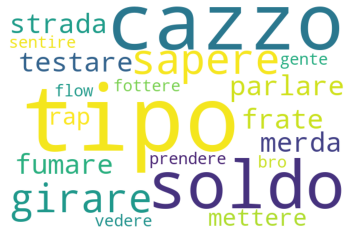

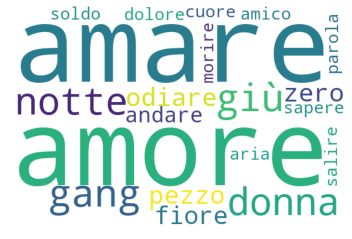

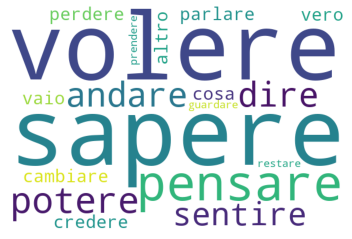

In [382]:
for i in range(5):
    draw_word_cloud(i,lda2,"It",vocab2, "white")
#passione
#esteriore
#parolaccie
#amore
#sentire

In [413]:
preds = np.argmax(doc_topics_en,axis=1)

In [414]:
doc_topics_it = lda2.transform(tf2)

In [415]:
preds_it = np.argmax(doc_topics_it,axis=1)

In [416]:
df.loc[df["lang"] == "English","topic"] = preds
df.loc[df["lang"] == "Italian","topic"] = preds_it

In [417]:
#df.to_csv("test.csv",sep=";")

In [418]:
full_df = pd.read_csv("cleaned_df_v5_with_langs.csv", delimiter=";", parse_dates=True, infer_datetime_format=True)

In [419]:
langdict = df[["id","topic"]].set_index("id").to_dict()["topic"]

In [420]:
full_df["topic"] = full_df["id"].map(langdict)

In [443]:
#full_df.to_csv("cleaned_lang_topics.csv",sep=";",index=False)

In [421]:
italians = full_df[full_df["lang"]=="Italian"]
englishs = full_df[full_df["lang"]=="English"]

In [422]:
topic_counts_eng = englishs.groupby(["date_chart","topic"]).size().unstack(fill_value=0)
topic_counts_eng = topic_counts_eng.div(topic_counts_eng.sum(axis=1), axis=0).reset_index()

In [423]:
topic_counts_it = italians.groupby(["date_chart","topic"]).size().unstack(fill_value=0)
topic_counts_it = topic_counts_it.div(topic_counts_it.sum(axis=1), axis=0).reset_index()

In [424]:
topic_counts_it

topic  date_chart       0.0       1.0       2.0       3.0       4.0
0      2006-05-07  0.000000  0.250000  0.125000  0.000000  0.625000
1      2006-05-14  0.000000  0.333333  0.200000  0.000000  0.466667
2      2006-05-21  0.000000  0.266667  0.200000  0.000000  0.533333
3      2006-05-28  0.000000  0.307692  0.230769  0.000000  0.461538
4      2006-06-04  0.000000  0.285714  0.142857  0.000000  0.571429
..            ...       ...       ...       ...       ...       ...
761    2021-04-22  0.078125  0.406250  0.234375  0.031250  0.250000
762    2021-04-29  0.065574  0.393443  0.163934  0.049180  0.327869
763    2021-05-06  0.046154  0.400000  0.169231  0.030769  0.353846
764    2021-05-13  0.061538  0.384615  0.200000  0.030769  0.323077
765    2021-05-20  0.046875  0.468750  0.093750  0.062500  0.328125

[766 rows x 6 columns]

In [425]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import ast
import seaborn as sns
import altair as alt
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from collections import defaultdict

In [426]:
topic_counts_eng['date_chart'] = pd.to_datetime(topic_counts_eng['date_chart'], format= '%Y-%m-%d')

In [427]:
topic_counts_eng = topic_counts_eng.set_index("date_chart")

In [ ]:
#
#rimembranza
#esplicito
#passione
#amore

In [431]:
topics_en = [(topic_counts_eng[0],"party"), (topic_counts_eng[1],"ricordi"), (topic_counts_eng[2],"esplicito"), (topic_counts_eng[3],"passione"),(topic_counts_eng[4],"amore")]
topics_en = list(map(lambda x : (x[0].resample("M").mean(), x[1]),topics_en))
trens_en = list(map(lambda x : (seasonal_decompose(x[0]).trend,x[1]),topics_en))

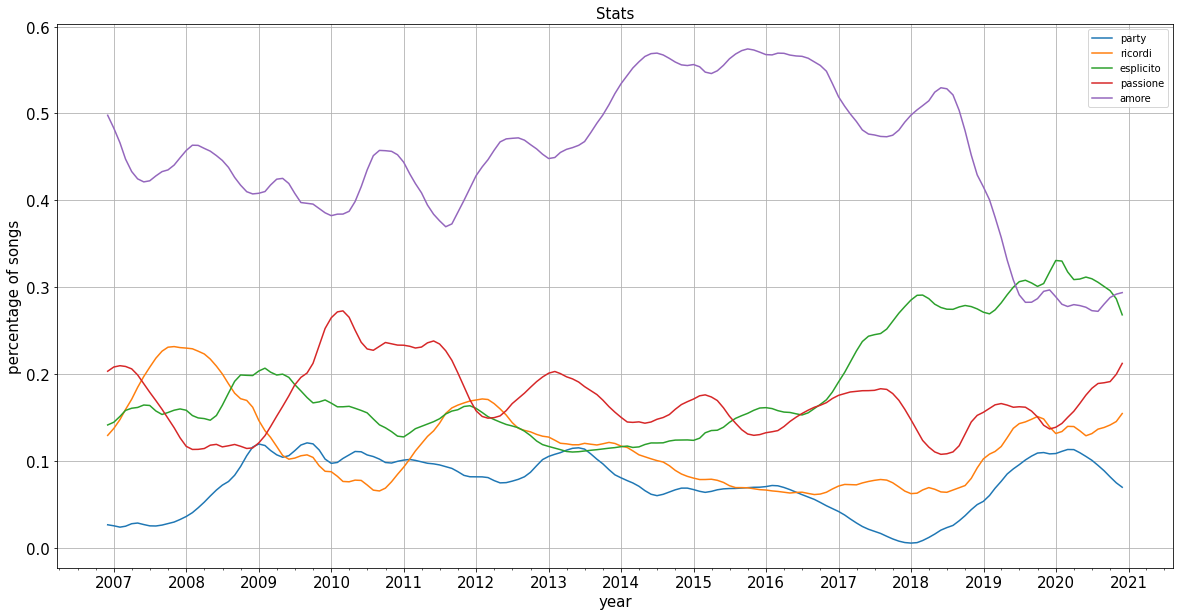

In [441]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

for topic in trens_en: 
    plt.plot(topic[0], label=topic[1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("percentage of songs", fontsize=15)

plt.savefig("topics_eng.png", dpi=300)

plt.show()

In [435]:
topic_counts_it['date_chart'] = pd.to_datetime(topic_counts_it['date_chart'], format= '%Y-%m-%d')

In [436]:
topic_counts_it = topic_counts_it.set_index("date_chart")

In [437]:
#passione
#esteriore
#parolaccie
#amore
#sentire

In [438]:
topics_it = [(topic_counts_it[0],"passione"), (topic_counts_it[1],"esteriore"), (topic_counts_it[2],"esplicito"), (topic_counts_it[3],"amore"),(topic_counts_it[4],"sentire")]
topics_it = list(map(lambda x : (x[0].resample("M").mean(), x[1]),topics_it))
trens_it = list(map(lambda x : (seasonal_decompose(x[0]).trend,x[1]),topics_it))

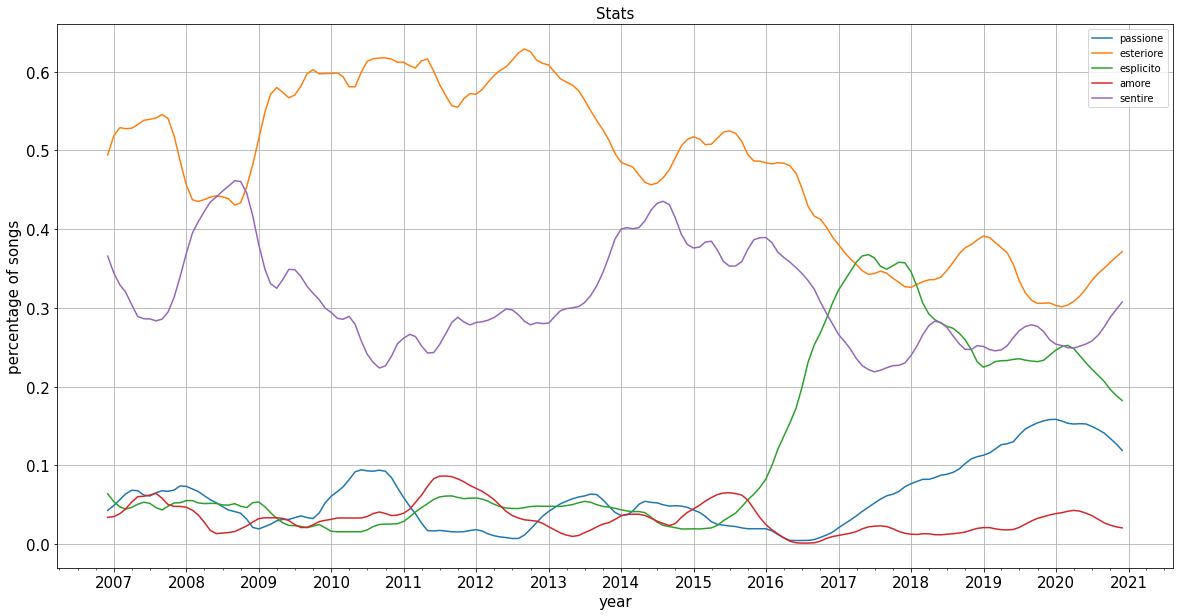

In [442]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

for topic in trens_it: 
    plt.plot(topic[0], label=topic[1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("percentage of songs", fontsize=15)

plt.savefig("topics_it.png", dpi=300)

plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [5], 'learning_decay': [.7]}

# Init the model
lda = LatentDirichletAllocation()

# Init Grid Search class
model = GridSearchCV(lda, search_params,n_jobs=-1)

model.fit(tf)
best_lda_model = model.best_estimator_
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(tf))

Best model's params:  {'learning_decay': 0.7, 'n_components': 5}
Best log likelihood score:  -145215.28644735558
Model perplexity:  155.50075755203258


In [ ]:
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, n_top_words)

Topic 0: niente, sai, tempo, giorno, giù, ancora, amo, senza, vivere, mondo, sempre, fine, cielo, fino, odio, sento, mentre, paura, altro, bisogno
Topic 1: soldi, gang, cazzo, fumo, sempre, sopra, tipo, frate, fuori, bitch, fatto, rap, vuole, giro, merda, okay, flow, bro, brr, bella
Topic 2: casa, stare, posso, sento, testa, male, fuori, oggi, pure, vai, sotto, strada, posto, cose, vedo, perso, dico, fatto, dentro, zero
Topic 3: senza, vita, amore, sempre, notte, cuore, mondo, dentro, occhi, sole, ancora, mare, cielo, può, parole, tempo, dimmi, volta, vorrei, adesso
Topic 4: cosa, voglio, bene, vuoi, ancora, adesso, tanto, male, meglio, sempre, sai, baby, dire, penso, vero, vieni, vita, ciò, fatto, dentro



In [ ]:
doc_topics = best_lda_model.transform(tf)

In [ ]:
preds = np.argmax(doc_topics,axis=1)

In [ ]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, tf, tf_vectorizer, mds='tsne')
#pyLDAvis.save_html(panel, "topics_bello.html")

In [ ]:
import pickle

In [ ]:
#pkl_filename = "topics_ita.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(best_lda_model, file)

In [ ]:
df_eng["topic"] = preds

In [ ]:
points = alt.Chart(df_it).mark_circle(
    opacity=0.8,
    size=100
).encode(
    x='TSNE_x',
    y='TSNE_y',
    tooltip=["song_name", "artists_names", "album_release_date", "tag_fimi","publisher","album_release_date", "lang", "intros", "topic"],
    color=alt.Color('topic:N')
)
'''
text = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).encode(
    text='publisher'
)
'''
al = points# + text
al.interactive().properties(
    width=1920,
    height=1080
)

alt.Chart(...)

In [ ]:
points = alt.Chart(df_eng).mark_circle(
    opacity=0.8,
    size=100
).encode(
    x='TSNE_x',
    y='TSNE_y',
    tooltip=["song_name", "artists_names", "album_release_date", "tag_fimi","publisher","album_release_date", "lang", "intros", "topic"],
    color=alt.Color('topic:N')
)
'''
text = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).encode(
    text='publisher'
)
'''
al = points# + text
al.interactive().properties(
    width=1920,
    height=1080
)

alt.Chart(...)

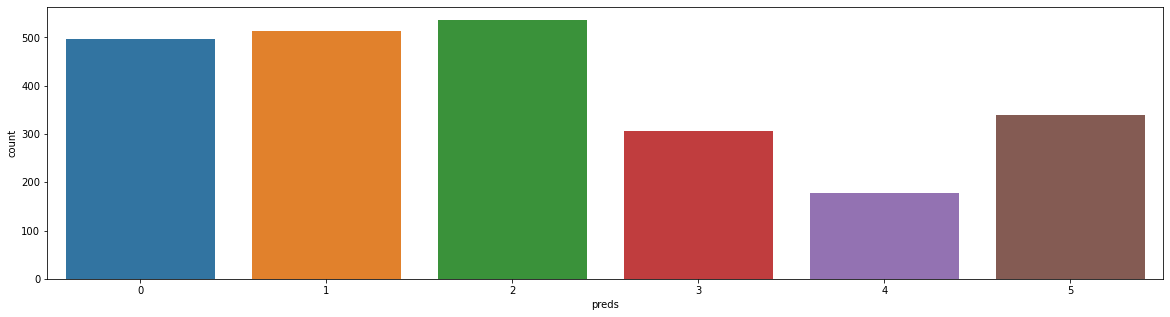

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="preds", data=pd.DataFrame(preds,columns=["preds"]))

In [ ]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, tf, tf_vectorizer, mds='tsne')
pyLDAvis.save_html(panel, "topicsb.html")